# LastFM Recommender Genre Topic Modeling: LDA
July [X], 2018

In [1]:
import sys
sys.executable

'/Users/brianmcmahon/anaconda3/envs/recommender/bin/python'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from os import path, getcwd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from PIL import Image

import gensim
from gensim import matutils, models

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

CWD = '/Volumes/BC_Clutch/Dropbox/recommender_system/'

In [3]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

In [4]:
tag_data = pd.read_csv('../data/recsys_tags2.csv')
tag_data = tag_data.set_index(['idx'])
tag_data['tags'] = tag_data['tags'].apply(lambda x: ', '.join(x.split('|')))
tag_data.head()

,name,tags
idx,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter..."
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt..."
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv..."
3,50 Cent,"00s, american, awesome, catchy, club, dance, g..."
4,A Day to Remember,"<3, acoustic, alternative, american, christian..."


In [5]:
tag_data.tags[0]

'00s, 2008, 90s, acoustic, acoustic rock, alternative, alternative rock, american, awesome, cute, grunge, guilty pleasure, hard rock, love, male vocalists, melancholic, other great tracks, pop, pop rock, post-grunge, prejebeno, punk, rock, romantic, soft rock, soundtrack'

In [6]:
tag_data.shape

(505, 2)

### Assumptions

In [7]:
data = tag_data.tags
n_topics = 6
seed = 42
ngram_range = (1,3)
ncols = 2

sw = set(STOPWORDS)

adds = ['rock','pop','hardcore','vocalist','male','female']
for word in adds:
    sw.add(word)


### LDA

In [24]:
# data = tag_data.tags
# num_topics = 6
# ngram_range = (1,2)
max_words = 10

# seed = 42
# n_clusters = 6

In [25]:
from gensim import corpora

Chart saved at ../charts/5.png


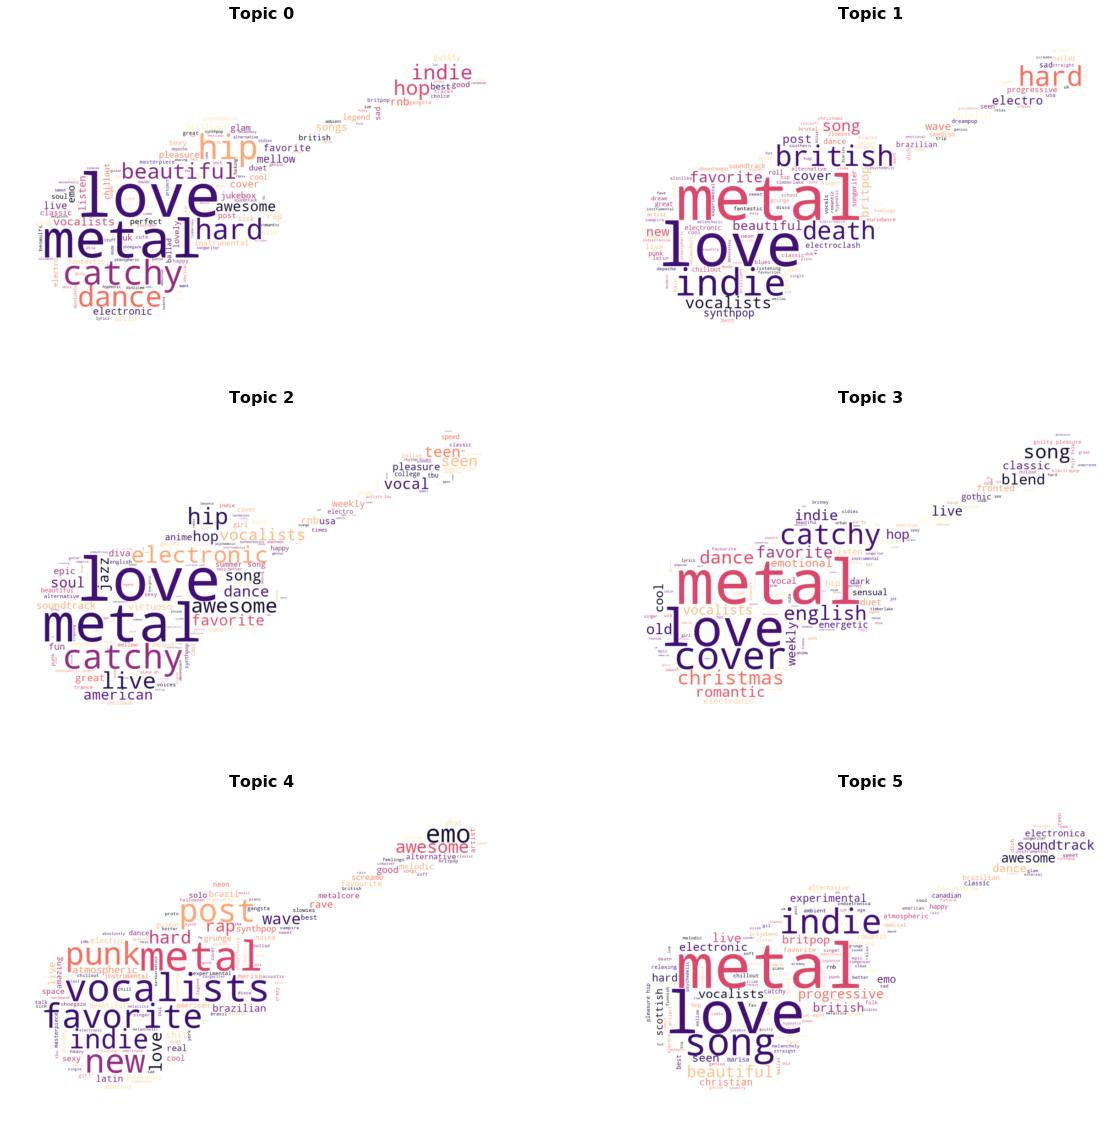

In [26]:
fig = plt.figure(figsize=(20,20))
topics_dict = {}
count_vectorizer = CountVectorizer(ngram_range=ngram_range,  stop_words='english', max_df=0.02, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(data)
counts = count_vectorizer.transform(data).transpose()
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=id2word, passes=10) # minimum_probability=0.03, 
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
topics = lda.print_topics(num_words=200)
# i = 0
for topic in topics:
#     print(topic)
    topics_dict[topic[0]] = lda_docs # , lda.log_perplexity
    nrows = math.ceil(n_topics / ncols)
    ax = fig.add_subplot(nrows,ncols,i+1)
    topics_dict[topic[0]] = topic
    title = " Topic: " + str(topic[0])
    filepath = '../charts/' + str(topic[0]) + '.png'
    
    generate_wordcloud(topic[1])

#     i+=1
plt.savefig(filepath)
print("Chart saved at {}".format(filepath))

In [27]:
from nltk import word_tokenize
import re

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in sw and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text

def return_max(tuple_list):
    x_max=0
    y_max=0
    for tup in tuple_list:
        x,y = tup
        if y >y_max:
            y_max=y
            x_max=x
    return x_max, y_max

<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<ipython-input-27-3e6dc882a89b>:6: DeprecationWarning: invalid escape sequence \-
  cleaned_text = [t for t in tokenized_text if t not in sw and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]


In [28]:
tokenized_data = []
for text in data:
    tokenized_data.append(clean_text(text))

In [29]:
dictionary = corpora.Dictionary(tokenized_data)

In [30]:
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

In [31]:
print(corpus[20])

[(17, 1), (26, 1), (28, 2), (29, 1), (44, 1), (86, 1), (88, 1), (179, 1)]


In [32]:
lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [33]:
lsi_model = models.LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [34]:
print("LDA Model:")
 
for idx in range(n_topics):
    # Print the first 4 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 4))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(n_topics):
    # Print the first 4 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 4))
 
print("=" * 20)

LDA Model:
Topic #0: 0.097*"metal" + 0.044*"alternative" + 0.025*"love" + 0.024*"hard"
Topic #1: 0.036*"indie" + 0.033*"love" + 0.032*"alternative" + 0.021*"songs"
Topic #2: 0.031*"love" + 0.026*"vocalists" + 0.018*"indie" + 0.017*"dance"
Topic #3: 0.040*"love" + 0.038*"alternative" + 0.024*"punk" + 0.024*"awesome"
Topic #4: 0.027*"dance" + 0.025*"electronic" + 0.022*"love" + 0.019*"vocalists"
Topic #5: 0.039*"indie" + 0.030*"alternative" + 0.028*"live" + 0.021*"love"
LSI Model:
Topic #0: 0.345*"love" + 0.331*"indie" + 0.330*"alternative" + 0.207*"live"
Topic #1: 0.885*"metal" + -0.176*"indie" + 0.147*"hard" + -0.139*"love"
Topic #2: -0.469*"indie" + -0.318*"alternative" + 0.274*"love" + 0.189*"catchy"
Topic #3: -0.340*"new" + -0.283*"favorite" + 0.270*"punk" + -0.253*"wave"
Topic #4: 0.479*"punk" + -0.383*"indie" + 0.245*"alternative" + 0.232*"favorite"
Topic #5: 0.262*"songs" + -0.231*"punk" + -0.228*"new" + 0.227*"love"


In [35]:
tag_data.head()

,name,tags
idx,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter..."
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt..."
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv..."
3,50 Cent,"00s, american, awesome, catchy, club, dance, g..."
4,A Day to Remember,"<3, acoustic, alternative, american, christian..."


In [36]:
bs_text = ''.join(tag_data[tag_data['name']=='Britney Spears']['tags'])

In [37]:
bs_text

"00s, 10s, 2007, 2008, 2009, 90's, 90s, <3, acoustic, addictive, alternative, amazing, american, awesome, ballad, beautiful, best, best christmas songs, best song ever, best songs of the 00s, beyonce, britney spears, catchy, christmas, classic, cool, country, cover, covers, cute, dance, dance-pop, disco, disney, diva, dubstep, electro, electro pop, electronic, electronica, electropop, emotional, energetic, english, epic, favorite, favorites, favourites, female, female vocalist, female vocalists, female voices, fun, gay, girl power, glam, gossip girl, great, great memories with my siss, guilty pleasure, guilty pleasures, handclaps, hot, justin timberlake, latin, legend, love, love at first listen, love it, loved, lovely, masterpiece, melodic, nice, oh so catchy, party, perfect, pop, pop covers, pop rock, pop singles, punk rock, remix, rnb, rock, sad, seen live, sensual, sex, sexy, singer-songwriter, soundtrack, summer song, sweet, tbu, teen pop, the best, top 40, underrated, urban, usa,

In [38]:
bow = dictionary.doc2bow(clean_text(text))

In [39]:
def return_topic(text, algorithm):
    bow = dictionary.doc2bow(clean_text(text))
    if algorithm == 'LSI':
        return return_max(lsi_model[bow])
    elif algorithm == 'LDA':
        return return_max(lda_model[bow])
    else:
        return None

In [40]:
print(return_topic(bs_text, 'LSI'))
print(return_topic(bs_text, 'LDA'))

(0, 7.544290160177123)
(2, 0.705176)


In [41]:
def return_genre(tup):
    genre_list = ['electronic','rock','rock','pop','electronic','urban', # 0 - 5
                  'rock', 'electronic','alternative','electronic','pop'] # 6 - 10
    topic_num = tup[0]
    
#     'pop' = return_topic()
    
    return genre_list[topic_num]

In [42]:
# def return_artist_topic(artist):
#     text = ''.join(tag_data[tag_data['name']==artist]['tags'])
#     bow = dictionary.doc2bow(clean_text(text))
#     return return_max(lda_model[bow])[0]
    

In [43]:
# return_artist_topic('Justin Timberlake')

In [44]:
# return_artist_topic('Frank Sinatra')

In [45]:
# return_artist_topic('Green Day')

In [46]:
# def return_genre(topic_tuple):
#     genre_dict = {}
#     genre_dict['rock'] = return_artist_topic('Foo Fighters')
#     genre_dict['pop'] = return_artist_topic('Justin Timberlake')
#     genre_dict['lounge'] = return_artist_topic('Frank Sinatra')
#     genre_dict['alternative'] = return_artist_topic('Green Day')
#     genre_dict['metal'] = return_artist_topic('Arch Enemy')

    

In [47]:
tag_data['topic_lsi'] = tag_data['tags'].apply(lambda x: return_topic(x,'LSI'))
tag_data['topic_lda'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA'))
tag_data['topic_lda_cluster'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA')[0])
tag_data['topic_lda_score'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA')[1])
tag_data['genre_lda'] = tag_data['topic_lda'].apply(lambda x: return_genre(x))

In [48]:
tag_data.head()

,name,tags,topic_lsi,topic_lda,topic_lda_cluster,topic_lda_score,genre_lda
idx,,,,,,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter...","(0, 2.450300937110937)","(3, 0.96344435)",3,0.963,pop
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt...","(0, 6.2200641716499145)","(0, 0.4861099)",0,0.499,electronic
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...","(0, 3.914575618118714)","(3, 0.41412327)",3,0.428,pop
3,50 Cent,"00s, american, awesome, catchy, club, dance, g...","(2, 1.26064265139866)","(4, 0.8467571)",4,0.844,electronic
4,A Day to Remember,"<3, acoustic, alternative, american, christian...","(0, 1.7036215582269043)","(0, 0.9533756)",0,0.953,electronic


In [49]:
# reture artists who best define their cluster
def return_distinct_artists(data, cluster_list):
    hs_dict = {} # hi score dictionary
    for topic in cluster_list:
        c_data = data[data['topic_lda_cluster']==topic].sort_values(by=['topic_lda_score'],ascending=False)
        top_list = []
        for i in range(min(3,len(c_data))):
            name = c_data.iloc[i]['name']
            cluster = c_data.iloc[i]['topic_lda_cluster']
            score = c_data.iloc[i]['topic_lda_score'] 
            top_list.append([name, cluster, score])
        hs_dict[topic] = top_list
    return hs_dict

In [50]:
distinct_artists = pd.DataFrame(return_distinct_artists(tag_data,tag_data.topic_lda_cluster.unique()))
distinct_artists

,3,0,4,1,5,2
0,"[Editors, 3, 0.9828420281410217]","[Metallica, 0, 0.9855141043663025]","[Daft Punk, 4, 0.9821124076843262]","[Depeche Mode, 1, 0.9934754967689514]","[U2, 5, 0.988143801689148]","[Katy Perry, 2, 0.9901016354560852]"
1,"[Panic! At the Disco, 3, 0.9794751405715942]","[Led Zeppelin, 0, 0.984987199306488]","[David Guetta, 4, 0.9771177172660828]","[Coldplay, 1, 0.9914106130599976]","[Erasure, 5, 0.9808695316314697]","[Mariah Carey, 2, 0.9876343011856079]"
2,"[Simple Plan, 3, 0.9772639870643616]","[Marilyn Manson, 0, 0.9841468930244446]","[The Prodigy, 4, 0.9688361287117004]","[Björk, 1, 0.9908576011657715]","[Snow Patrol, 5, 0.9804368019104004]","[Beyoncé, 2, 0.9874465465545654]"


In [51]:
# td2
# td2.sort_values(by=['topic_lda'],ascending=False)

In [52]:
# LSI model
# the highest topic attributed to britney spears and the 
# details of that topic
# print(return_max(lsi_model[bow]))
# lsi_model.print_topic(return_max(lsi_model[bow])[0])

In [53]:
# LDA model
# the highest topic attributed to britney spears and the 
# details of that topic
# print(return_max(lda_model[bow]))
# lda_model.print_topic(return_max(lda_model[bow])[0])